# query from osm autocomplete

In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

import geopandas as gpd



from earthtext.osm import multilabel
from earthtext.io import io
osmcodes = multilabel.kvmerged.keyvals_codes


In [2]:
from earthtext.datamodules.components import chipmultilabel

In [3]:
model_ckpt_fname = "/opt/data/models/osm_emcoder_2024-04-25_12:01-training.ckpt"
model_conf_fname = model_ckpt_fname[:-5] + ".yaml"

if not os.path.isfile(model_ckpt_fname) or not os.path.isfile(model_conf_fname):
    raise ValueError("cannot find model or conf")

conf = OmegaConf.load(model_conf_fname)
conf.dataloader['get_chip_id'] = True
d = hydra.utils.instantiate(conf.dataloader)

2024-04-28 03:13:10.636 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1047 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000
2024-04-28 03:13:13.612 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1051 - read train split with 60295 chip files (out of 60396)
2024-04-28 03:13:13.613 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1056 - max cache size is -1
2024-04-28 03:13:14.324 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1047 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-28 03:13:14.925 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1051 - read val split with 12288 chip files (out of 12304)
2024-04-28 03:13:14.926 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1056 - max cache size is -1
2024-04-

[[-118.45066667 -118.45066667 -118.472      -118.472      -118.45066667]
 [  34.14933333   34.17066667   34.17066667   34.14933333   34.14933333]]


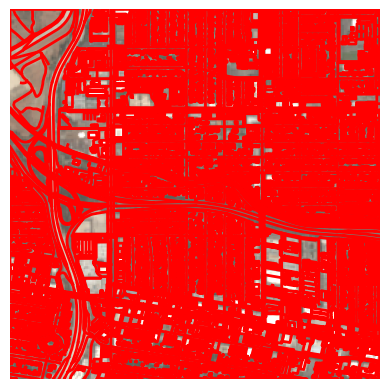

In [13]:
osm_tags = ['landuse=*', 'crop=*', 'building=*', 'water=*', 'natural=*', 'waterway=*', 'highway=*']
idx  = np.random.randint(len(d.train_dataset.metadata))
d.train_dataset.plot_chip_with_tags(idx, osm_tags)

In [2]:
import pandas as pd
import numpy as np


def autocomplete_query(
    constraints: tuple[int],  # user contraints, ex: (0,0,...,1,-1)
    df: pd.DataFrame,
    n_samples: int = 1,
):
    df = df.query("split == 'train'")
    counts = np.stack(df.onehot_count)
    kept_rows_mask = np.array((True,) * df.shape[0])  # mask of kept rows
    constrained_cols_ix = np.nonzero(constraints)[0]  # indices of constrained columns
    
    for col_ix in constrained_cols_ix:
        constraint = constraints[col_ix]
        if constraint == 1:
            kept_rows_mask *= (counts[:, col_ix] > 0)
        elif constraint == -1:
            kept_rows_mask *= (counts[:, col_ix] == 0)

    n_kept_rows = kept_rows_mask.sum()
    if n_kept_rows > 0:
        df = df.iloc[kept_rows_mask]  # keep rows that satisfy the constraints
        return (df.sample(n=n_samples, replace=True, axis=0), n_kept_rows)  # sample w replacement
    else:
        return (df[0:0], 0)  # return 0 rows

# load osm encoder model

In [2]:
model_ckpt_fname = "/opt/data/models/osm_emcoder_2024-04-22_23:40.ckpt"
model_conf_fname = model_ckpt_fname[:-5] + ".yaml"

if not os.path.isfile(model_ckpt_fname) or not os.path.isfile(model_conf_fname):
    raise ValueError("cannot find model or conf")

In [3]:
conf = OmegaConf.load(model_conf_fname)
m = hydra.utils.instantiate(conf.model)
m.load_state_dict(torch.load(model_ckpt_fname))

<All keys matched successfully>

# load embeddings for searching (test data)

### TODO: encapsulate normalization and area/count/length selection only in dataset class

In [4]:
# ensure we get chip ids
conf.dataloader['get_chip_id'] = True
d = hydra.utils.instantiate(conf.dataloader)

In [5]:
d = hydra.utils.instantiate(conf.dataloader)

2024-04-23 00:35:33.695 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-23 00:35:36.816 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read train split with 60295 chip files (out of 60396)
2024-04-23 00:35:36.816 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-23 00:35:37.526 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-23 00:35:38.165 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read val split with 12288 chip files (out of 12304)
2024-04-23 00:35:38.165 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-

In [6]:
d.disable_chip_loading()
search_dataloader = lambda: d.test_dataloader()


In [7]:
embeddings = []
chip_ids = []
for batch in pbar(search_dataloader()):
    be = batch['embedding'].detach().numpy()
    for i in range(len(be)):
        embeddings.append(be[i])
        chip_ids.append(batch['chip_id'][i])
embeddings = np.r_[embeddings]
embeddings.shape

100% (420 of 420) |######################| Elapsed Time: 0:00:03 Time:  0:00:030000


(13411, 768)

# simulate user query

In [124]:
# user query
has = ['building=*', 'waterway=*']
hasnot = []

In [125]:
for c in has + hasnot:
    if not c in osmcodes.keys():
        raise ValueError(f"osm code '{c}' not found")

has_codes = [osmcodes[i] for i in has]
hasnot_codes = [osmcodes[i] for i in hasnot]

In [126]:
query = np.zeros(297)
for c in has_codes:
    query[c] = 1
for c in hasnot_codes:
    query[c] = -1
sum(query)

2.0

# autocomplete query (with train data) averaging the query sample

(normalizing if dataloader is configured that way)

In [127]:
n_samples = 2
s, nkept_rows =  autocomplete_query(query, d.train_dataset.metadata,n_samples)
print(f"query autocompleted with {n_samples} samples out of {nkept_rows} compatible osm chips from the train data")

4368
query autocompleted with 2 samples out of 4368 compatible osm chips from the train data


In [128]:
s

onehot_count  \
chip_id                                                            
188f885aedd4d  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13, 13...   
1bd3e533bde00  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 32, 7,...   

                                                     onehot_area  \
chip_id                                                            
188f885aedd4d  [0.0, 0.0, 305.760675304968, 0.0, 305.76067530...   
1bd3e533bde00  [0.0, 0.0, 5379.656190789705, 0.0, 0.0, 5379.6...   

                                                   onehot_length  \
chip_id                                                            
188f885aedd4d  [0.0, 0.0, 75.21538072398133, 0.0, 75.21538072...   
1bd3e533bde00  [0.0, 0.0, 287.35379715120814, 0.0, 0.0, 287.3...   

                                                   string_labels    col  \
chip_id                                                                   
188f885aedd4d  [building=*, building=house, highway=*, highwa...  34560   
1bd3e533bde00  [building=*, building=industrial, highway=*, h...  41984   

                 row                                           geometry  \
chip_id                                                                   
188f885aedd4d  16896  POLYGON ((-122.09867 40.57067, -122.09867 40.5...   
1bd3e533bde00  51456  POLYGON ((-121.48000 37.69067, -121.48000 37.7...   

                                               esawc_proportions  split  
chip_id                                                                  
188f885aedd4d  {'10': 0.0962371826171875, '100': 0.0, '20': 0...  train  
1bd3e533bde00  {'10': 0.0514373779296875, '100': 0.0, '20': 0...  train

In [129]:
autocompleted_query = np.hstack([np.stack(s.onehot_count.values) , np.stack(s.onehot_area.values), np.stack(s.onehot_length.values) ]).mean(axis=0).reshape(1, -1)
autocompleted_query.shape

(1, 297)

In [130]:
if d.train_dataset.normalize_input:
    autocompleted_query = (autocompleted_query - inputs_mean) / inputs_std

# predict embeddings from autocompleted query

In [131]:
query_embeddings = m(torch.Tensor(autocompleted_query)).detach().numpy()
query_embeddings.shape

(1, 768)

# search by similarity in the embeddings space

In [132]:
def get_top10_sim(vectorbase, query):
    ntargets = (vectorbase.T / np.linalg.norm(vectorbase,axis=1)).T
    nquery   = query / np.linalg.norm(query)
    sims = ntargets.dot(nquery)
    top10idxs = np.argsort(sims)[-10:]
    return top10idxs

In [133]:
top10idxs = get_top10_sim(embeddings, query_embeddings[0])
top10idxs

array([11864, 11537,  3916, 11406,  7842,  9385,  4263, 11536,  9537,
        7250])

In [134]:
ds = search_dataloader().dataset
ds.cache = {}
ds.disable_chip_loading = False
chips = [ds[i] for i in top10idxs]


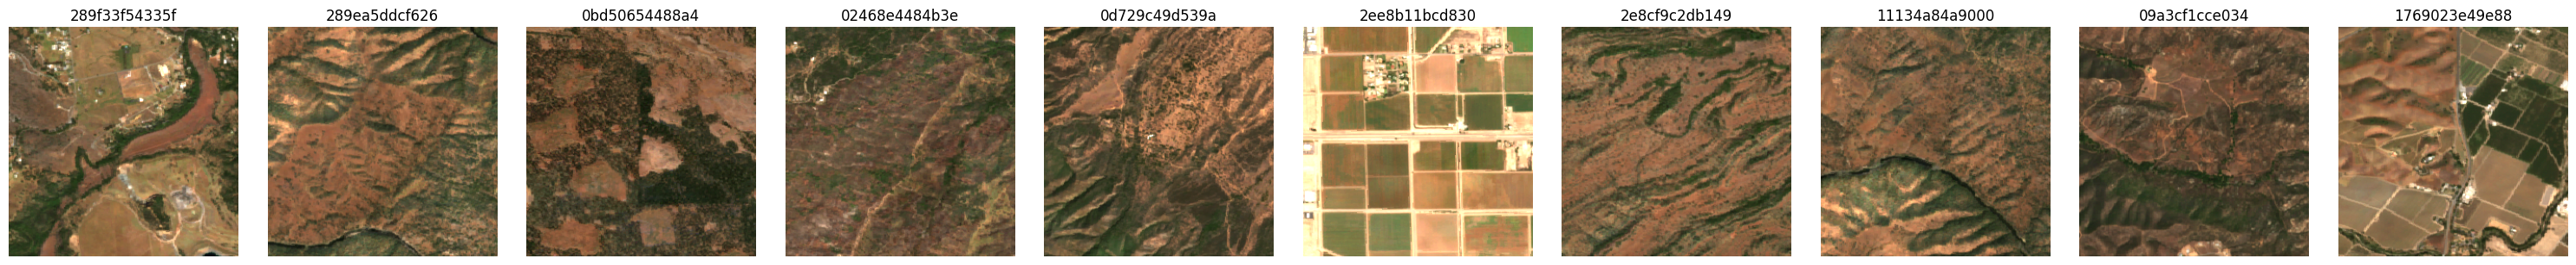

In [135]:
for ax,i in subplots(len(chips)):
    c = chips[i]
        
    cimg = c['chip'][:3]
    cimg = np.transpose(cimg, [1,2,0]) 
    cimg = cimg / 2000
    cimg[cimg>1] = 1
    plt.imshow(cimg)
    plt.title(c['chip_id'])
    plt.axis("off")

In [15]:
def get_top10_sim(vectorbase, query):
    ntargets = (vectorbase.T / np.linalg.norm(vectorbase,axis=1)).T
    nquery   = query / np.linalg.norm(query)
    sims = ntargets.dot(nquery)
    top10idxs = np.argsort(sims)[-10:]
    return top10idxs
    
def query_osm(has, hasnot, nsamples_autocomplete, embeddings, osm_encoder):

    # get codes
    for c in has + hasnot:
        if not c in osmcodes.keys():
            raise ValueError(f"osm code '{c}' not found")
    
    has_codes = [osmcodes[i] for i in has]
    hasnot_codes = [osmcodes[i] for i in hasnot]

    # build query
    query = np.zeros(297)
    for c in has_codes:
        query[c] = 1
    for c in hasnot_codes:
        query[c] = -1

    # autocomplete
    s, nkept_rows =  autocomplete_query(query, d.train_dataset.metadata,nsamples_autocomplete)
    print(f"query autocompleted with {nsamples_autocomplete} samples out of {nkept_rows} compatible osm chips from the train data")

    autocompleted_query = np.hstack([np.stack(s.onehot_count.values) , np.stack(s.onehot_area.values), np.stack(s.onehot_length.values) ]).mean(axis=0).reshape(1, -1)
    print (f"autocompleted query checksum {autocompleted_query.sum():.4f}")
    # predict embeddings
    query_embeddings = osm_encoder(torch.Tensor(autocompleted_query)).detach().numpy()

    # search by similarity in embeddings space
    top10idxs = get_top10_sim(embeddings, query_embeddings[0])
    return top10idxs

def show_query_results(idxs):
    ds = search_dataloader().dataset
    ds.cache = {}
    ds.disable_chip_loading = False
    chips = [ds[i] for i in idxs]
    for ax,i in subplots(len(chips)):
        c = chips[i]
            
        cimg = c['chip'][:3]
        cimg = np.transpose(cimg, [1,2,0]) 
        cimg = cimg / 2000
        cimg[cimg>1] = 1
        plt.imshow(cimg)
        plt.title(c['chip_id'])
        plt.axis("off")

In [32]:
has = ['building=*']
hasnot = []

idxs = query_osm(has, hasnot, nsamples_autocomplete=2, embeddings=embeddings, osm_encoder=m)
show_query_results(idxs)

query autocompleted with 2 samples out of 6225 compatible osm chips from the train data
autocompleted query checksum 3294509.3680


query autocompleted with 2 samples out of 6225 compatible osm chips from the train data
autocompleted query checksum 1675020.2433


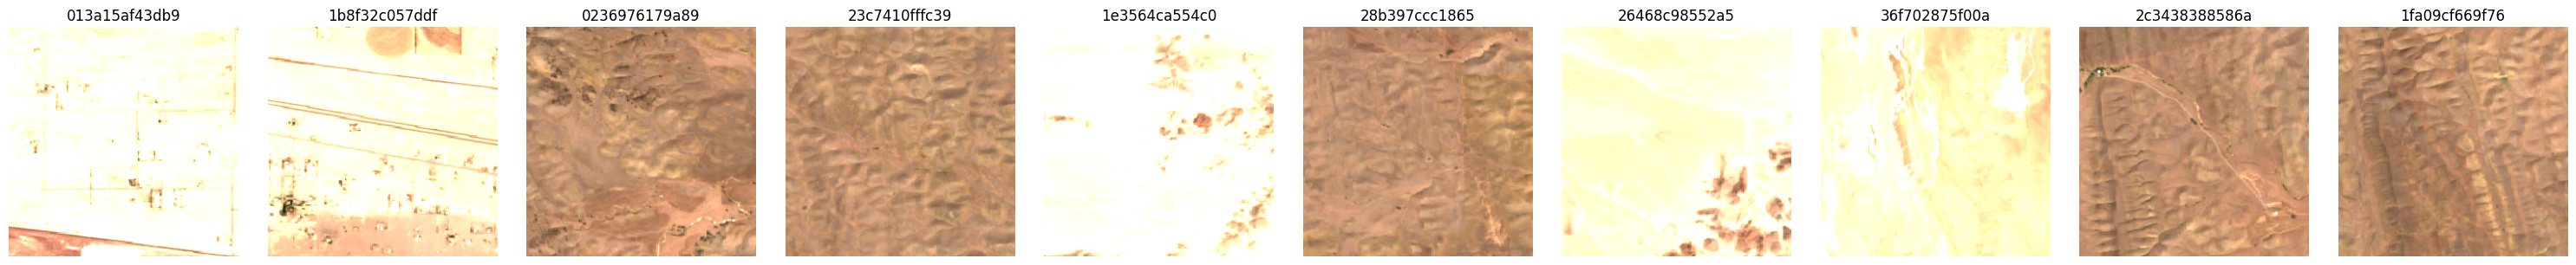

In [33]:
has = ['building=*']
hasnot = []

idxs = query_osm(has, hasnot, nsamples_autocomplete=2, embeddings=embeddings, osm_encoder=m)
show_query_results(idxs)

query autocompleted with 2 samples out of 39353 compatible osm chips from the train data
autocompleted query checksum 21107.9634


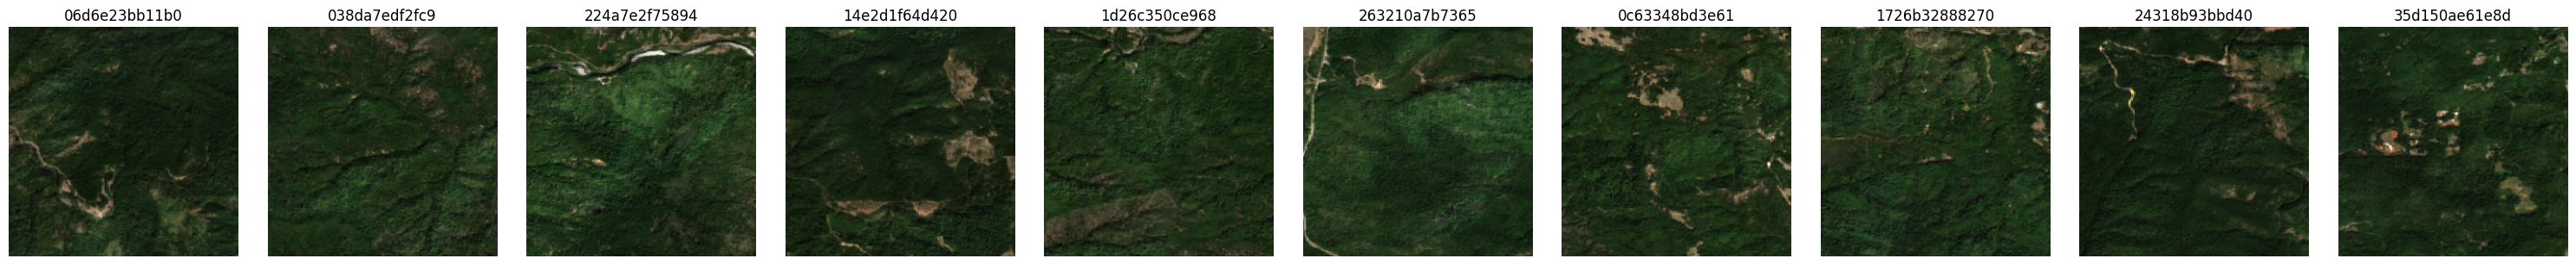

In [36]:
has = ['waterway=*']
hasnot = []

idxs = query_osm(has, hasnot, nsamples_autocomplete=2, embeddings=embeddings, osm_encoder=m)
show_query_results(idxs)

query autocompleted with 2 samples out of 39353 compatible osm chips from the train data
autocompleted query checksum 1279718.2586


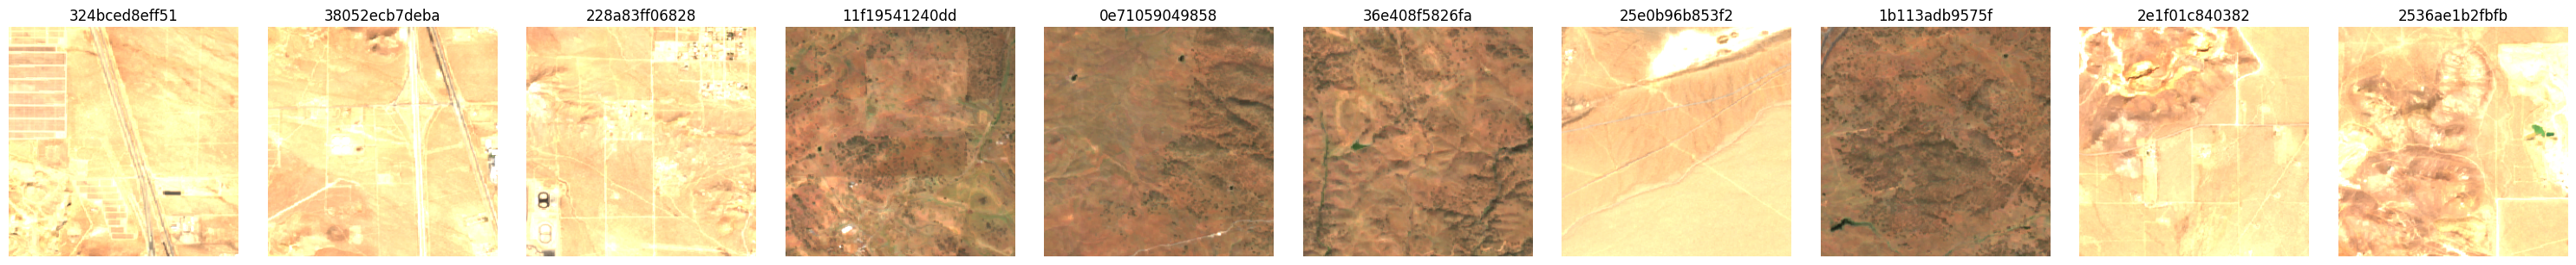

In [37]:
has = ['waterway=*']
hasnot = []

idxs = query_osm(has, hasnot, nsamples_autocomplete=2, embeddings=embeddings, osm_encoder=m)
show_query_results(idxs)

In [38]:
idxs = query_osm(has, hasnot, nsamples_autocomplete=1, embeddings=embeddings, osm_encoder=m)
#show_query_results(idxs)


query autocompleted with 1 samples out of 39353 compatible osm chips from the train data
autocompleted query checksum 4858.6714
